## Module 3 - In this jupyter notebook, perfomance indicators are calculated 
* Step 3a - Set up: Import modules/libraries, inport data, create output folder
* Step 3b - Calculate uniformity
* Step 3c - Calculate efficiency (beneficial fraction)
* Step 3d - Calculate adquacy
* Step 3e - Calculate relative water deficit 
**==========================================================================================================**

![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig3_1.png?raw=true)

**==========================================================================================================**
#### <span style='background :lightgreen' > References:
* Karimi, P., Bongani, B., Blatchford, M., and de Fraiture, C.: Global satellite-based ET products for the local level irrigation management: An application of irrigation performance assessment in the sugarbelt of Swaziland, Remote Sensing, 11, 705, 2019.
* Bastiaanssen, W. G., and Bos, M.: Irrigation performance indicators based on remotely sensed data: a review of literature, Irrigation and drainage systems, 13, 291-311, 1999.
* Bastiaanssen, W. G., Van der Wal, T., and Visser, T.: Diagnosis of regional evaporation by remote sensing to support irrigation performance assessment, Irrigation and Drainage Systems, 10, 1-23, 1996.

## Step 3a - Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## i) Import packages/libraries

In [2]:
import os
import sys
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# change the directory to where the modules are saved

# change the directory to where the modules are saved/ change working directory to 'Modules' folder
sys.path.insert(0,'/content/drive/My Drive/WAPORWP/Modules')
from GIS_functions import GIS_function as gis

## ii) Import the input data
* Seasonal T, AETI, ETp 

In [3]:
# get seasonal data
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

# seasonal transpiration, actual evapotranspiration & potential evapotranspiration
input_folderSeasonalT   = os.path.join(dir_proj, dir_data, "2L2_T_season") 
T_fhs                   = sorted(glob.glob(input_folderSeasonalT  + '/*.tif'))

input_folderSeasonalET  = os.path.join(dir_proj, dir_data, "2L2_AETI_season") 
AETI_fhs                = sorted(glob.glob(input_folderSeasonalET  + '/*.tif'))

input_folderSeasonalETp = os.path.join(dir_proj, dir_data, "2L1_ETp_season") 
ETp_fhs                 = sorted(glob.glob(input_folderSeasonalETp  + '/*.tif'))

## \### Import the input data (this section is added)
* Inputting field data\
By inputting different types of field data into the WaPOR model, we can greatly improve the accuracy, and get over some of limitations of remote sensing.
And by modifying the field data to be compatible with the WaPOR model we can get full advantage of the model.

In [4]:
# input mask layer
mask_array = gis.OpenAsArray("/content/drive/MyDrive/WAPORWP/Data/1Boundary/mask_irrigation_types.tif", nan_values=True)
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo("/content/drive/MyDrive/WAPORWP/Data/1Boundary/mask_irrigation_types.tif")
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])

In [14]:
### lets assume Water input equales 14777833.4
Water_input_season = [14777833.4] ### assuming the calculations are for many seasons
water_input_field_list = []
mask_pixel_count = np.count_nonzero(mask_array == 1)

for w in Water_input_season:
  # by distributing the input equaly through the area
  pixel_water_input = w / mask_pixel_count
  water_input_field = np.where(mask_array == 1, pixel_water_input, mask_array)
  water_input_field_list.append(water_input_field)

water_input_field_list

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)]

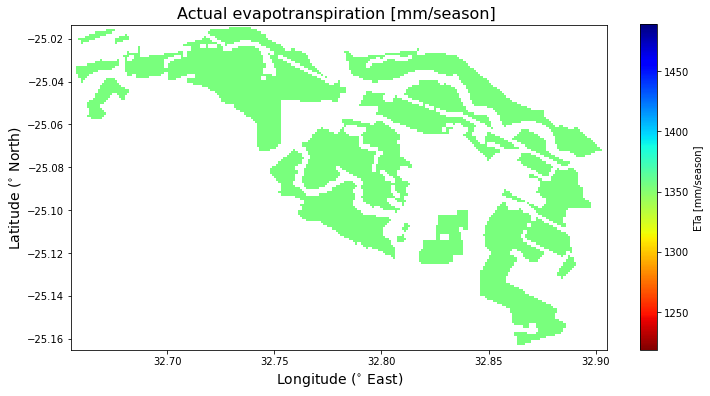

In [15]:
for wi in water_input_field_list:
  # ploting
  plt.figure(figsize = (12,8))
  plt.imshow(wi, cmap='jet_r', vmin=np.nanmin(wi), vmax=np.nanmax(wi), extent=spatial_extent)
  plt.colorbar(shrink=0.75, label='ETa [mm/season]')
  plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
  plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
  plt.title('Actual evapotranspiration [mm/season] ', fontsize=16)
  # plt.clim(0,1600)
  plt.show()

In [9]:
# exporting the data for later use
field_data_dir =  os.path.join(dir_proj, dir_data, "field_Water_input")

if not os.path.exists(field_data_dir):
    os.makedirs(field_data_dir)

for i,field_input in enumerate(water_input_field_list):
  file_name = os.path.join(dir_proj, dir_data, "field_Water_input",  f"season{str(i+1)}")
  np.save(file_name,field_input) ### for now it's enough to save it as an array

## iii) Output folder: Make one or connect to the existing one

In [10]:
# output_folder
# the directory of the output folder
output_folderBF = os.path.join(dir_proj, dir_data, "3_BeneficialFraction") 
output_folderAd = os.path.join(dir_proj, dir_data, "3_Adequacy") 

# Make one if the folder does not exit
if not os.path.exists(output_folderBF):
    os.makedirs(output_folderBF)
if not os.path.exists(output_folderAd):
    os.makedirs(output_folderAd)

## Step 3b - Calculate uniformity of water consumption
* Equity is defined as the coefficients of variation (CV) of seasonal ETa in the area of interest.
* It measures the evenness of the water supply in an irrigation scheme. 
* Note: CV of 0 to 10% is good, 10 to 25% is fair and CV > 25% is poor uniformity (Bastiaanssen et al., 1996) 
<br/> 

comment: If there is field data representing the distribution of water in the field it can be used to replace WaPOR AETI layer, and calibrate it for later usage.

In [11]:
# Uniformity of water Consumption 
# get seasonal AETI
# AETI_fhs = glob.glob(r'..\Data\2L2_AETI_season\*.tif') 

for i in range(len(AETI_fhs)):
    AETI = gis.OpenAsArray(AETI_fhs[i], nan_values=True)
    
    AETIm   = np.nanmean(AETI)
    AETIsd  = np.nanstd(AETI)
    
    CV_AETI = (AETIsd / AETIm) * 100
    
    # Identify the date from the file name
    date  = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ') 
    
    if CV_AETI < 10:
        U = 'Good Uniformity'
    if (CV_AETI >= 10) and (CV_AETI < 25):
        U = 'Fair Uniformity'
    else: 
        U = 'Poor Uniformity'

    print ('CV of AETI in', date, '=', round(CV_AETI, 1), ',', U)

CV of AETI in ETa 2016-10-01 to 2017-09-30 = 8.7 , Poor Uniformity


## Step 3c - Calculate efficiency (beneficial fraction)
* Beneficial fraction is the ratio of the water that is consumed as transpiration compared to overall field water consumption (ETa). 
* $Beneficial fraction = \frac{T_a}{ET_a}$
* It is a measure of the efficiency of on farm water and agronomic practices in use of water for crop growth.

\### field data will be used instead of AETI. But it will be better if you have data representing the different areas of the field.

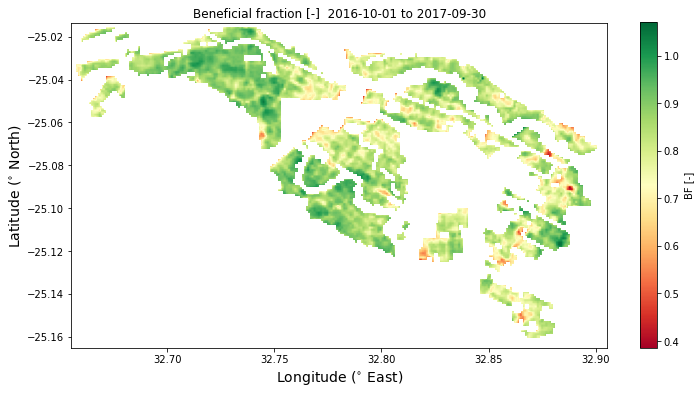

In [16]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = T_fhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster
  
### field data will be used
for Tfh, ETfh in zip(T_fhs, water_input_field_list):
    T    = gis.OpenAsArray(Tfh,  nan_values=True)
    # AETI = gis.OpenAsArray(ETfh, nan_values=True)
    
    T_over_AETI = T/ETfh
    
    # Identify the date from the file name
    date  = os.path.basename(Tfh).split('.')[0].replace('T', '').replace('_', ' ') 
    
    # update the file name, and save into output folder
    basename  = os.path.basename(Tfh).replace('T', 'BF')  
    output_fn = os.path.join(output_folderBF, basename)
    gis.CreateGeoTiff(output_fn, T_over_AETI, driver, NDV, xsize, ysize, GeoT, Projection) 
    
    # Plot the raster map
    seasonal = T_over_AETI
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='BF [-]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Beneficial fraction [-] ' + date)
#     plt.clim(0,1)
    plt.show ()

## Step 3d - Calculate adequacy (relative evapotranspiration)
$Adequacy= \frac{ET_a}{ET_p}$

\### field data will be used instead of AETI. But it will be better if you have data representing the different areas of the field.

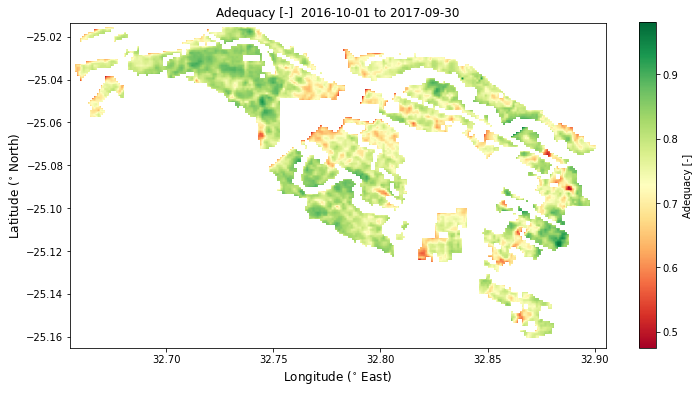

In [19]:
## Calculate and save raster adequacy layer

# collecting Geoinfo such as projection, the x and y axis
in_fh = ETp_fhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for wf, ETpfh in zip(water_input_field_list, ETp_fhs): ### replaced AETI_fhs
    # AETI = gis.OpenAsArray(ETfh,  nan_values=True)
    ETp  = gis.OpenAsArray(ETpfh, nan_values=True)
    
    wf_by_ETp = AETI / ETp
    
    # Identify the date from the file name
    date  = os.path.basename(ETpfh).split('.')[0].replace('ETc', '').replace('_', ' ') 
        
    # update the file name, and save into output folder
    basename  = os.path.basename(ETpfh).replace('ETc', 'Adequacy')
    output_fn = os.path.join(output_folderAd, basename)
    gis.CreateGeoTiff(output_fn, wf_by_ETp, driver, NDV, xsize, ysize, GeoT, Projection) 
  
    # Plot the raster map
    seasonal = wf_by_ETp
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Adequacy [-]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
    plt.title('Adequacy [-] ' + date)
    plt.show ()

## Step 3e - Calculate Relative water Deficit (RWD)
$RWD= 1-\frac{ET_a}{ET_x}$
<br/>${ET_x} = $ Can be ETp or 99 percentile of the actual evapotranspiration

comment: field data will be used instead of AETI. But it will be better if you have data representing the different areas of the field.

In [20]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = AETI_fhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster
   
for i in range(len(AETI_fhs)):
    AETI = gis.OpenAsArray(AETI_fhs[i], nan_values=True)
    
    # reshape the arrays
    AETI1_1D  = np.reshape(AETI,  AETI.shape[0]*AETI.shape[1])
    ETx       = np.nanpercentile(AETI1_1D, 99)
    
    AETI_mean = np.nanmean(AETI)
   
    RWD = 1-(AETI_mean/ETx)
    
    # Identify the date from the file name
    date  = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ') 
    
    print ('Relative water deficit', date, '=', round(RWD, 2))

Relative water deficit ETa 2016-10-01 to 2017-09-30 = 0.14
